### **Import and Install Libraries. Download Dataset.**

In [1]:
!pip install torchinfo

In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os
import sys
import glob
import h5py
import numpy as np
from torch.utils.data import Dataset
from __future__ import print_function
import os
import argparse
from scipy.stats import entropy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
import sklearn.metrics as metrics
import copy
import math
import time

In [3]:
!wget --no-check-certificate https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip
!unzip -q modelnet40_ply_hdf5_2048.zip;

--2024-04-26 05:45:21--  https://shapenet.cs.stanford.edu/media/modelnet40_ply_hdf5_2048.zip
Resolving shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)... 171.67.77.19
Connecting to shapenet.cs.stanford.edu (shapenet.cs.stanford.edu)|171.67.77.19|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 435212151 (415M) [application/zip]
Saving to: ‘modelnet40_ply_hdf5_2048.zip’

modelnet40_ply_hdf5 100%[===================>] 415.05M  3.94MB/s    in 85s     

2024-04-26 05:46:46 (4.91 MB/s) - ‘modelnet40_ply_hdf5_2048.zip’ saved [435212151/435212151]



In [4]:
import warnings

# Ignore specific warnings related to multiprocessing and os.fork
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*os.fork.*")

In [5]:
#Class for your arguments
class Args:
    def __init__(self):
        self.exp_name = 'exp'
        self.model = 'dgcnn'
        self.dataset = 'modelnet40'
        self.batch_size = 32
        self.test_batch_size = 16
        self.epochs = 250
        self.use_sgd = True
        self.lr = 0.001
        self.momentum = 0.9
        self.no_cuda = False
        self.seed = 1
        self.eval = False
        self.num_points = 1024
        self.dropout = 0.5
        self.emb_dims = 1024
        self.k = 10
        self.model_path = ''

In [6]:
#Method to retrieve your training and testing files
def getDataFiles(list_filename):
    print(list_filename)
    return [line.rstrip() for line in open(list_filename)]

In [7]:
#Store your dataset in the folder 'data'
import shutil
os.mkdir('data')
shutil.move('modelnet40_ply_hdf5_2048', 'data')
TRAIN_FILES = getDataFiles( \
    os.path.join('data/modelnet40_ply_hdf5_2048/train_files.txt'))
TEST_FILES = getDataFiles(\
    os.path.join('data/modelnet40_ply_hdf5_2048/test_files.txt'))

data/modelnet40_ply_hdf5_2048/train_files.txt
data/modelnet40_ply_hdf5_2048/test_files.txt


In [8]:
def cal_loss(pred, gold, smoothing=True):
    ''' Calculate cross entropy loss, apply label smoothing if needed. '''

    gold = gold.contiguous().view(-1)

    if smoothing:
        eps = 0.2
        n_class = pred.size(1)

        one_hot = torch.zeros_like(pred).scatter(1, gold.view(-1, 1), 1)
        one_hot = one_hot * (1 - eps) + (1 - one_hot) * eps / (n_class - 1)
        log_prb = F.log_softmax(pred, dim=1)

        loss = -(one_hot * log_prb).sum(dim=1).mean()
    else:
        loss = F.cross_entropy(pred, gold, reduction='mean')

    return loss

In [9]:
class IOStream():
    """
    A utility class for outputting text to both console and a file. This class provides a method to concurrently print
    information to the console and append it to a file. This can be particularly useful for logging purposes in
    applications like long-running processes where monitoring and retaining output history is necessary.

    Attributes:
    f (file object): File object used to append text to the specified file.
    """
    def __init__(self, path):
        """
        Initialize the IOStream by opening or creating a file for appending text.

        Parameters:
        path (str): The file path where text will be appended. If the file does not exist, it will be created.
        """
        self.f = open(path, 'a')  # Open the file in append mode.

    def cprint(self, text):
        """
        Prints text to the console and appends it to the file initialized in this class instance.

        Parameters:
        text (str): The text to be printed and logged.
        """
        print(text)  # Print text to console.
        self.f.write(text + '\n')  # Append text to file and add a newline.
        self.f.flush()  # Flush the internal buffer, ensuring all file operations are completed immediately.

    def close(self):
        """
        Closes the file associated with this instance. It is important to call this method to free up system resources.
        """
        self.f.close()  # Close the file to release resources.


### **Calculate 10 k-nearest neighbors based on the Euclidean distance $(x_1-x_2)^2$**

In [10]:
def knn(x, k):
    inner = -2*torch.matmul(x.transpose(2, 1), x)
    xx = torch.sum(x**2, dim=1, keepdim=True)
    pairwise_distance = -xx - inner - xx.transpose(2, 1)
    idx = pairwise_distance.topk(k=k, dim=-1)[1]   # (batch_size, num_points, k)
    # print(idx[1,:,1].size, 'idx of knn')
    return idx

In [11]:
def get_graph_feature(x, k=10, idx=None):
    # print(x.shape, 'Input x to get_graph_feature')
    batch_size = x.size(0)
    num_points = x.size(2)
    x = x.view(batch_size, -1, num_points)
    if idx is None:
        idx = knn(x, k=k)   # (batch_size, num_points, k)
    device = torch.device('cuda')
    # print(idx)
    idx_base = torch.arange(0, batch_size, device=device).view(-1, 1, 1)*num_points

    idx = idx + idx_base
    # print(idx[1,1,:], 'idx of get_graph_feature')
    idx = idx.view(-1)

    _, num_dims, _ = x.size()

    x = x.transpose(2, 1).contiguous()   # (batch_size, num_points, num_dims)  -> (batch_size*num_points, num_dims) #   batch_size * num_points * k + range(0, batch_size*num_points)
    feature = x.view(batch_size*num_points, -1)[idx, :]
    feature = feature.view(batch_size, num_points, k, num_dims)
    x = x.view(batch_size, num_points, 1, num_dims).repeat(1, 1, k, 1)

    feature = torch.cat((feature-x, x), dim=3).permute(0, 3, 1, 2).contiguous()

    return feature

### **DGCNN**

In [12]:
class DGCNN(nn.Module):
    def __init__(self, args, output_channels=40):
        super(DGCNN, self).__init__()
        self.args = args
        self.k = args.k

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(args.emb_dims)

        self.conv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                   self.bn1,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, args.emb_dims, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.linear1 = nn.Linear(args.emb_dims*2, 512, bias=False)
        self.bn6 = nn.BatchNorm1d(512)
        self.dp1 = nn.Dropout(p=args.dropout)
        self.linear2 = nn.Linear(512, 256)
        self.bn7 = nn.BatchNorm1d(256)
        self.dp2 = nn.Dropout(p=args.dropout)
        self.linear3 = nn.Linear(256, output_channels)

    def forward(self, x):
        batch_size = x.size(0)
        x = get_graph_feature(x, k=self.k)
        x = self.conv1(x)
        x1 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x1, k=self.k)
        x = self.conv2(x)
        x2 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x2, k=self.k)
        x = self.conv3(x)
        x3 = x.max(dim=-1, keepdim=False)[0]

        x = get_graph_feature(x3, k=self.k)
        x = self.conv4(x)
        x4 = x.max(dim=-1, keepdim=False)[0]

        x = torch.cat((x1, x2, x3, x4), dim=1)

        x = self.conv5(x)
        x1 = F.adaptive_max_pool1d(x, 1).view(batch_size, -1)
        x2 = F.adaptive_avg_pool1d(x, 1).view(batch_size, -1)
        x = torch.cat((x1, x2), 1)

        x = F.leaky_relu(self.bn6(self.linear1(x)), negative_slope=0.2)
        x = self.dp1(x)
        x = F.leaky_relu(self.bn7(self.linear2(x)), negative_slope=0.2)
        x = self.dp2(x)
        x = self.linear3(x)
        return x

### **DGCNN EE1**

In [13]:
class eeModel_E1(nn.Module):
    def __init__(self, args, output_channels=40):
        super(eeModel_E1, self).__init__()

        self.args = args
        self.k = args.k

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm1d(args.emb_dims)

        ################################Base Model###################################
        self.baseModelconv1 = nn.Sequential(nn.Conv2d(6, 64, kernel_size=1, bias=False),
                                       self.bn1,
                                       nn.LeakyReLU(negative_slope=0.2))
        self.baseModelconv2 = nn.Sequential(nn.Conv2d(64*2, 64, kernel_size=1, bias=False),
                                   self.bn2,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.baseModelconv3 = nn.Sequential(nn.Conv2d(64*2, 128, kernel_size=1, bias=False),
                                   self.bn3,
                                   nn.LeakyReLU(negative_slope=0.2))
        #############################################################################

        #############################Short Branch####################################
        self.shortBranch = nn.Sequential(nn.Linear(256*2, 512, bias=False),
                                         nn.BatchNorm1d(512),
                                         nn.LeakyReLU(negative_slope=0.2),
                                         nn.Dropout(p=args.dropout),
                                         nn.Linear(512, 256),
                                         nn.BatchNorm1d(256),
                                         nn.LeakyReLU(negative_slope=0.2),
                                         nn.Dropout(p=args.dropout),
                                         nn.Linear(256, output_channels))
        ################################################################################

        ####################################Long Branch#################################
        self.conv4 = nn.Sequential(nn.Conv2d(128*2, 256, kernel_size=1, bias=False),
                                   self.bn4,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.conv5 = nn.Sequential(nn.Conv1d(512, args.emb_dims, kernel_size=1, bias=False),
                                   self.bn5,
                                   nn.LeakyReLU(negative_slope=0.2))
        self.longBranch_fc = nn.Sequential(nn.Linear(args.emb_dims*2, 512, bias=False),
                                         nn.BatchNorm1d(512),
                                         nn.LeakyReLU(negative_slope=0.2),
                                         nn.Dropout(p=args.dropout),
                                         nn.Linear(512, 256),
                                         nn.BatchNorm1d(256),
                                         nn.LeakyReLU(negative_slope=0.2),
                                         nn.Dropout(p=args.dropout),
                                         nn.Linear(256, output_channels))
        ####################################################################################

    def forward(self, x):
        batch_size = x.size(0)
        x_baseModelconv1 = self.baseModelconv1(get_graph_feature(x, k=self.k)).max(dim=-1, keepdim=False)[0]
        x_baseModelconv2 = self.baseModelconv2(get_graph_feature(x_baseModelconv1, k=self.k)).max(dim=-1, keepdim=False)[0]
        x_baseModelconv3 = self.baseModelconv3(get_graph_feature(x_baseModelconv2, k=self.k)).max(dim=-1, keepdim=False)[0]
        x_baseModel = torch.cat((x_baseModelconv1, x_baseModelconv2, x_baseModelconv3), dim=1)
        x_shortBranch, x_longBranch = self.get_short_branch_output(x_baseModel, batch_size), self.get_long_branch_output(x_baseModelconv1, x_baseModelconv2, x_baseModelconv3, batch_size)
        return x_shortBranch, x_longBranch

    def get_short_branch_output(self, x_baseModel, batch_size):
        x_shortBranch = self.shortBranch(torch.cat((F.adaptive_max_pool1d(x_baseModel, 1).view(batch_size, -1),
                                                    F.adaptive_avg_pool1d(x_baseModel, 1).view(batch_size, -1)), 1))
        return x_shortBranch

    def get_long_branch_output(self, x_baseModelconv1, x_baseModelconv2, x_baseModelconv3, batch_size):
        x4_longBranch = self.conv4(get_graph_feature(x_baseModelconv3, k=self.k)).max(dim=-1, keepdim=False)[0]
        x_longBranch = self.conv5(torch.cat((x_baseModelconv1, x_baseModelconv2, x_baseModelconv3, x4_longBranch), dim=1))
        x_longBranch = torch.cat((F.adaptive_max_pool1d(x_longBranch, 1).view(batch_size, -1),
                                  F.adaptive_avg_pool1d(x_longBranch, 1).view(batch_size, -1)), 1)
        x_longBranch = self.longBranch_fc(x_longBranch)
        return x_longBranch

In [14]:
def load_data(partition):
    """
    Load pointcloud data and labels from HDF5 files based on the specified partition (train or test).
    This function is designed to work within a filesystem structure expected for ModelNet40 dataset files,
    aggregating data from multiple files into a single array for both data points and labels.

    Parameters:
    partition (str): Specifies which dataset partition to load. Expected values are 'train' or 'test'.

    Returns:
    tuple: A tuple containing two numpy arrays: one for the data (pointclouds) and one for the labels.
    """
    # Define base directory relative to this script's location.
    BASE_DIR = os.path.dirname(os.path.abspath(r'\data\modelnet40_ply_hdf5_2048'))
    # Define data directory path combining base directory with the data subdirectory.
    DATA_DIR = os.path.join(BASE_DIR, 'data')

    # Initialize lists to hold data and labels from all files.
    all_data = []
    all_label = []

    # Loop over each file matching the pattern for the specified partition.
    for h5_name in glob.glob(os.path.join(DATA_DIR, 'modelnet40_ply_hdf5_2048', f'ply_data_{partition}*.h5')):
        # Open the HDF5 file for reading.
        f = h5py.File(h5_name)
        # Load all data points as float32 and labels as int64 from the file.
        data = f['data'][:].astype('float32')
        label = f['label'][:].astype('int64')
        # Ensure the file is closed after its contents are loaded.
        f.close()

        # Append the data and labels to their respective lists.
        all_data.append(data)
        all_label.append(label)

    # Concatenate all data and labels from the list into single numpy arrays.
    all_data = np.concatenate(all_data, axis=0)
    all_label = np.concatenate(all_label, axis=0)

    # Return the aggregated data and labels.
    return all_data, all_label

In [15]:
def translate_pointcloud(pointcloud):
    """
    Apply a random translation to a pointcloud. This is done by first scaling the pointcloud with a random factor
    and then adding a small random shift. This can be used as a data augmentation technique to make models robust
    to variations in object position and scale.

    Parameters:
    pointcloud (np.array): A numpy array of shape (N, 3) where N is the number of points.

    Returns:
    np.array: The translated pointcloud as a new numpy array of type 'float32'.
    """
    xyz1 = np.random.uniform(low=2./3., high=3./2., size=[3])  # Random scaling factors.
    xyz2 = np.random.uniform(low=-0.2, high=0.2, size=[3])    # Random translation offsets.

    translated_pointcloud = np.add(np.multiply(pointcloud, xyz1), xyz2).astype('float32')  # Apply scaling and translation
    return translated_pointcloud

In [16]:
def jitter_pointcloud(pointcloud, sigma=0.01, clip=0.02):
    """
    Apply Gaussian noise to a pointcloud. Each point's position is altered by adding a noise vector drawn from a
    Gaussian distribution, clipped to a maximum magnitude to prevent excessive perturbation. This augmentation
    promotes robustness to small variations or noise.

    Parameters:
    pointcloud (np.array): A numpy array of shape (N, C) where N is the number of points and C is the number of coordinates.
    sigma (float): Standard deviation of the Gaussian noise.
    clip (float): Maximum allowed value for noise applied to the point coordinates.

    Returns:
    np.array: The jittered pointcloud.
    """
    N, C = pointcloud.shape  # Number of points N and dimensions C in the pointcloud.
    pointcloud += np.clip(sigma * np.random.randn(N, C), -1*clip, clip)  # Add clipped Gaussian noise.
    return pointcloud

In [17]:
class ModelNet40(Dataset):
    """
    Dataset class for ModelNet40, which includes methods for loading and preprocessing pointcloud data for training or testing.
    Data augmentation (translation and shuffling) is applied to training data to improve model generalization.

    Attributes:
    num_points (int): Number of points per pointcloud to use.
    partition (str): Dataset partition to use, either 'train' or 'test'.
    """
    def __init__(self, num_points, partition='train'):
        """
        Initialize the dataset object, loading data and labels according to the specified partition.

        Parameters:
        num_points (int): Number of points to sample from each pointcloud.
        partition (str): Which dataset partition to use, 'train' or 'test'.
        """
        self.data, self.label = load_data(partition)  # Load dataset.
        self.num_points = num_points  # Points per pointcloud.
        self.partition = partition  # Dataset partition.

    def __getitem__(self, item):
        """
        Retrieve a pointcloud and its label, applying data augmentation if in training mode.

        Parameters:
        item (int): Index of the pointcloud to retrieve.

        Returns:
        tuple: Tuple containing the pointcloud and its label.
        """
        pointcloud = self.data[item][:self.num_points]  # Get the subset of points.
        label = self.label[item]
        if self.partition == 'train':  # Conditionally apply augmentations.
            pointcloud = translate_pointcloud(pointcloud)
            np.random.shuffle(pointcloud)  # Shuffle points to remove any order bias.
        return pointcloud, label

    def __len__(self):
        """
        Return the total number of pointclouds in the dataset.

        Returns:
        int: The number of pointclouds.
        """
        return self.data.shape[0]  # Number of pointclouds in the dataset.

In [18]:
# Dictionary for ModelNet40 classes. Helpful when printing confusion matrix. Note that ModelNet40 sorts its classes alphabetically
label_dict = {
    'airplane': 0,
    'bathtub': 1,
    'bed': 2,
    'bench': 3,
    'bookshelf': 4,
    'bottle': 5,
    'bowl': 6,
    'car': 7,
    'chair': 8,
    'cone': 9,
    'cup': 10,
    'curtain': 11,
    'desk': 12,
    'door': 13,
    'dresser': 14,
    'flower_pot': 15,
    'glass_box': 16,
    'guitar': 17,
    'keyboard': 18,
    'lamp': 19,
    'laptop': 20,
    'mantel': 21,
    'monitor': 22,
    'night_stand': 23,
    'person': 24,
    'piano': 25,
    'plant': 26,
    'radio': 27,
    'range_hood': 28,
    'sink': 29,
    'sofa': 30,
    'stairs': 31,
    'stool': 32,
    'table': 33,
    'tent': 34,
    'toilet': 35,
    'tv_stand': 36,
    'vase': 37,
    'wardrobe': 38,
    'xbox': 39
}
modes = list(label_dict.keys())

### **Training and Testing algorithms**

In [19]:
def train(args, io):
    # 1. Determine the size of the original training dataset
    total_train_samples = len(ModelNet40(partition='train', num_points=args.num_points))
    train_size = int(0.75 * total_train_samples)  # 60% of the original training dataset
    validation_size = total_train_samples - train_size  # Remaining samples for validation

    # 2. Split the original training dataset
    train_dataset, validation_dataset = random_split(ModelNet40(partition='train', num_points=args.num_points), [train_size, validation_size])

    # 3. Create DataLoader for the training and validation datasets
    train_loader = DataLoader(train_dataset, num_workers=2, batch_size=args.batch_size, shuffle=True, drop_last=True)
    validation_loader = DataLoader(validation_dataset, num_workers=2, batch_size=args.test_batch_size, shuffle=True, drop_last=False)

    # Test DataLoader remains unchanged
    test_loader = DataLoader(ModelNet40(partition='test', num_points=args.num_points), num_workers=2, batch_size=args.test_batch_size, shuffle=True, drop_last=False)
    history = {"1": {"train": {"loss": [], "accuracy": []}, "validation":{"loss": [], "accuracy": []}},
              "2": {"train": {"loss": [], "accuracy": []}, "validation":{"loss": [], "accuracy": []}},
              "T": {"train": {"loss": [], "accuracy": []}, "validation":{"loss": [], "accuracy": []}}}
    loss1_list = []
    loss2_list = []
    acc1_list = []
    acc2_list = []
    eStopThreshold, eStopCounter = 8, 0
    device = "cuda" # Set up your NVIDIA GPU.
    model = eeModel_E1(args).to(device) #Initialize your model.
    print(summary(model))## Print your model summary.
    print("Let's use", torch.cpu.device_count(), "GPUs!") ## Print how many GPUs are being used.

    #Set up your optimizer and loss
    if args.use_sgd:
        print("Use SGD")
        opt = optim.SGD(model.parameters(), lr=args.lr*100, momentum=args.momentum, weight_decay=1e-4)
    else:
        print("Use Adam")
        opt = optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)

    scheduler = CosineAnnealingLR(opt, args.epochs, eta_min=args.lr)
    criterion = cal_loss

    best_test_acc = 0
    for epoch in range(args.epochs):
        loss1Total, loss2Total, totalLoss = 0, 0, 0
        acc1Total, acc2Total, totalAcc = 0, 0, 0
        loss1Total_v, loss2Total_v, valLoss = 0, 0, 0
        acc1Total_v, acc2Total_v, valAcc = 0, 0, 0
        train_loss = 0.0
        loss = 0
        bestAcc = 0
        best_loss = 100
        preValLoss = 100
        scheduler.step()
        ####################
        # Train
        ####################
        count = 0.0
        model.train()
        train_pred = []
        train_true = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device).squeeze() # Send your input data and label to device e.g. GPU, CPU
            data = data.permute(0, 2, 1) # Permute your data for subsequent operations
            batch_size = data.size()[0] # Retrieve your batch size
            opt.zero_grad() # Zero your optimizer
            logits1, logits2 = model(data) # Compute unnormalized model outputs e.g. short branch and long branch outputs
            loss1, loss2 = criterion(logits1, label), criterion(logits2, label) # Calculate your losses e.g. short branch and long branch losses
            loss1_list.append(loss1.item()) # Append your short branch losses
            loss2_list.append(loss2.item()) # Append your long branch losses
            loss1Total += loss1.item() # Aggregate your short branch losses
            loss2Total += loss2.item() # Aggregate your long branch losses
            totalLoss += 0.5*loss1.item() + 0.5*loss2.item() # Average your loss
            loss1.backward(retain_graph=True) # Backward propagate your short branch loss
            loss2.backward(retain_graph=True) # Backward propagate your long branch loss
            _, predicted1 = torch.max(logits1, 1) # Max pool your short branch predicitions
            _, predicted2 = torch.max(logits2, 1) # Max pool your long branch predicitions
            acc1 = metrics.accuracy_score(label.detach().cpu().numpy(), predicted1.detach().cpu().numpy()) # Calculate your short branch accuracy
            acc2 = metrics.accuracy_score(label.detach().cpu().numpy(), predicted2.detach().cpu().numpy()) # Calculate your long branch accurac
            acc1_list.append(acc1) # Append your short branch accuracies
            acc2_list.append(acc2) # Append your long branch accuracies
            acc1Total += acc1 # Aggregate your short branch accuracies
            acc2Total += acc2 # Aggregate your long branch accuracies
            totalAcc += 0.5*acc1+0.5*acc2 # Average your accuracy
            opt.step() # Step your optimizer
            count += batch_size # Recursively add number of prediciton counts
        loss1Total = loss1Total/len(train_loader) # Normalize your short branch losses
        loss2Total = loss2Total/len(train_loader) # Normalize your long branch losses
        totalLoss = totalLoss/len(train_loader) # Normalize your total loss
        acc1Total = acc1Total/len(train_loader) # Normalize your short branch accuracy
        acc2Total = acc2Total/len(train_loader) # Normalize your long branch accuracy
        totalAcc = totalAcc/len(train_loader) # Normalize your total accuracy
        ############## Append to your history dictionaty################
        history["1"]["train"]["loss"].append(loss1Total)
        history["1"]["train"]["accuracy"].append(acc1Total)
        history["2"]["train"]["loss"].append(loss2Total)
        history["2"]["train"]["accuracy"].append(acc2Total)
        history["T"]["train"]["loss"].append(totalLoss)
        history["T"]["train"]["accuracy"].append(totalAcc)
        ###############################################################
        print("epoch {} --> trainLoss: {:0.3f}, trainAcc: {:0.3f}" # Print your epoch, total normalized loss, total normalized accuracy.
                  .format(epoch+1, totalLoss, totalAcc), end="")

        ####################### Validation is identical training####################
        if validation_loader:
          with torch.no_grad():
            model.eval() # Set up your model for evaluation
            for data, label in validation_loader:
              data, label = data.to(device), label.to(device).squeeze()
              data = data.permute(0, 2, 1)
              batch_size = data.size()[0]
              opt.zero_grad()
              logits1, logits2 = model(data) ## ADD TWO LOGITS

              loss1, loss2 = criterion(logits1, label.long()), criterion(logits2, label.long())
              loss1Total_v += loss1.item()
              loss2Total_v += loss2.item()
              valLoss += 0.5*loss1.item() + 0.5*loss2.item()

              _, predicted1 = torch.max(logits1, 1)
              _, predicted2 = torch.max(logits2, 1)
              acc1 = metrics.accuracy_score(label.detach().cpu().numpy(), predicted1.detach().cpu().numpy())
              acc2 = metrics.accuracy_score(label.detach().cpu().numpy(), predicted2.detach().cpu().numpy())

              acc1Total_v += acc1
              acc2Total_v += acc2
              valAcc += 0.5*acc1 + 0.5*acc2

            loss1Total_v = loss1Total_v/len(validation_loader)
            loss2Total_v = loss2Total_v/len(validation_loader)
            valLoss = valLoss/len(validation_loader)
            acc1Total_v = acc1Total_v/len(validation_loader)
            acc2Total_v = acc2Total_v/len(validation_loader)
            valAcc = valAcc/len(validation_loader)

            history["1"]["validation"]["loss"].append(loss1Total_v)
            history["1"]["validation"]["accuracy"].append(acc1Total_v)
            history["2"]["validation"]["loss"].append(loss2Total_v)
            history["2"]["validation"]["accuracy"].append(acc2Total_v)
            history["T"]["validation"]["loss"].append(valLoss)
            history["T"]["validation"]["accuracy"].append(valAcc)

          print(", validLoss: {:0.3f}, validAcc: {:0.3f}"
                  .format(valLoss, valAcc))
#############Save best performing model if current test accuracy outperforms the recorded best accuracy#############
          if valLoss <= best_loss:
            # Save the model with the lowest validation loss.
            best_loss = valLoss
            torch.save(model.state_dict(), 'checkpoints/%s/models/model.pth' % args.exp_name)
            print("Model Saved!")
#####################################################################################################################

########################Stop training if validation loss is increasing#############################
          if valLoss >= preValLoss:
            eStopCounter += 1
            if eStopCounter >= eStopThreshold:
              print("Training Stopped!")
              break;
          else:
            eStopCounter = 0
          preValLoss = valLoss
        else:
          print("")
#####################################################################################################
    return model, history

In [20]:
train_demo = ModelNet40(1024)
test_demo = ModelNet40(1024, 'test')

In [21]:
#Initialize your hyperparametr arguments
args = Args()

In [22]:
if not os.path.exists('checkpoints'):
  os.makedirs('checkpoints')
if not os.path.exists('checkpoints/'+args.exp_name):
  os.makedirs('checkpoints/'+args.exp_name)
if not os.path.exists('checkpoints/'+args.exp_name+'/'+'models'):
  os.makedirs('checkpoints/'+args.exp_name+'/'+'models')
os.system('cp main.py checkpoints'+'/'+args.exp_name+'/'+'main.py.backup')
os.system('cp model.py checkpoints' + '/' + args.exp_name + '/' + 'model.py.backup')
os.system('cp util.py checkpoints' + '/' + args.exp_name + '/' + 'util.py.backup')
os.system('cp data.py checkpoints' + '/' + args.exp_name + '/' + 'data.py.backup')

256

In [23]:
io = IOStream('checkpoints/' + args.exp_name + '/run.log')
args.no_cuda = False
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [24]:
model, history = train(args, io)

Layer (type:depth-idx)                   Param #
eeModel_E1                               --
├─BatchNorm2d: 1-1                       128
├─BatchNorm2d: 1-2                       128
├─BatchNorm2d: 1-3                       256
├─BatchNorm2d: 1-4                       512
├─BatchNorm1d: 1-5                       2,048
├─Sequential: 1-6                        128
│    └─Conv2d: 2-1                       384
│    └─BatchNorm2d: 2-2                  (recursive)
│    └─LeakyReLU: 2-3                    --
├─Sequential: 1-7                        128
│    └─Conv2d: 2-4                       8,192
│    └─BatchNorm2d: 2-5                  (recursive)
│    └─LeakyReLU: 2-6                    --
├─Sequential: 1-8                        256
│    └─Conv2d: 2-7                       16,384
│    └─BatchNorm2d: 2-8                  (recursive)
│    └─LeakyReLU: 2-9                    --
├─Sequential: 1-9                        --
│    └─Linear: 2-10                      262,144
│    └─BatchNorm1d: 2

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


epoch 1 --> trainLoss: 2.956, trainAcc: 0.380, validLoss: 2.478, validAcc: 0.496
Model Saved!
epoch 2 --> trainLoss: 2.375, trainAcc: 0.563, validLoss: 2.178, validAcc: 0.640
Model Saved!
epoch 3 --> trainLoss: 2.219, trainAcc: 0.630, validLoss: 2.074, validAcc: 0.671
Model Saved!
epoch 4 --> trainLoss: 2.127, trainAcc: 0.669, validLoss: 2.004, validAcc: 0.705
Model Saved!
epoch 5 --> trainLoss: 2.074, trainAcc: 0.691, validLoss: 1.983, validAcc: 0.728
Model Saved!
epoch 6 --> trainLoss: 2.018, trainAcc: 0.717, validLoss: 1.889, validAcc: 0.757
Model Saved!
epoch 7 --> trainLoss: 1.978, trainAcc: 0.732, validLoss: 1.849, validAcc: 0.785
Model Saved!
epoch 8 --> trainLoss: 1.938, trainAcc: 0.749, validLoss: 1.808, validAcc: 0.793
Model Saved!
epoch 9 --> trainLoss: 1.919, trainAcc: 0.762, validLoss: 1.794, validAcc: 0.807
Model Saved!
epoch 10 --> trainLoss: 1.892, trainAcc: 0.769, validLoss: 1.788, validAcc: 0.815
Model Saved!
epoch 11 --> trainLoss: 1.867, trainAcc: 0.781, validLoss: 

In [25]:
def infer(sLoader, threshold=0.05, verbose=False):
    """
    @Inference: we compare the output confidence (entropy) at a branch with a certain threshold

    Parameters:
    sLoader (DataLoader): Iterable over the dataset, provides batches of (inputs, groundTruth).
    threshold (float): Entropy threshold used to decide the stopping point for shortBranch.
    verbose (bool): If True, prints entropy values when they are below the threshold.

    Returns:
    tuple: A tuple containing the recording dictionary of accuracies, list of predicted labels, and overall accuracy.
    """

    # Softmax layer initialization for converting outputs to probability distributions
    softmaxLayer = nn.Softmax(dim=1)

    # Initialize accuracy and list to hold predictions
    acc = 0
    predicted = []

    # Dictionary to keep track of accuracy per branch (shortBranch: 0, longBranch: 1)
    recorder = {x: [] for x in range(2)}

    # Set model to evaluation mode
    model.eval()

    # Disables gradient calculations for inference, saving memory and computations
    with torch.no_grad():
        for inputs, gTruth in sLoader:
            # Move input and ground truth data to GPU
            inputs, gTruth = inputs.to('cuda'), gTruth.to('cuda')
            batch_size = inputs.size()[0] # Retrieve your batch size
            # Permute dimensions of inputs to fit model's expected input shape
            inputs = inputs.permute(0, 2, 1)
            # Process inputs through the base part of the model
            x_baseModelconv1 = model.baseModelconv1(get_graph_feature(inputs, k=args.k)).max(dim=-1, keepdim=False)[0]
            x_baseModelconv2 = model.baseModelconv2(get_graph_feature(x_baseModelconv1, k=args.k)).max(dim=-1, keepdim=False)[0]
            x_baseModelconv3 = model.baseModelconv3(get_graph_feature(x_baseModelconv2, k=args.k)).max(dim=-1, keepdim=False)[0]
            x = torch.cat((x_baseModelconv1, x_baseModelconv2, x_baseModelconv3), dim=1)
            # Iterate through each sample in the batch
            for iSample in range(x.shape[0]):
                # Max pooling to reduce dimensions followed by permute and squeeze to fit to branch
                out1 = model.get_short_branch_output(x[iSample:iSample+1], 1)
                # Apply softmax to get probabilities
                y = softmaxLayer(out1)
                # Calculate the entropy of the output probabilities
                e = entropy(y.detach().cpu().numpy().squeeze(), base=10)
                # Check if entropy is below the threshold
                if e <= threshold:
                    if verbose:
                        print(e)  # Optionally print the entropy
                    _, label = torch.max(out1, 1)
                    predicted.append(label)
                    if label == gTruth[iSample].item():
                        recorder[0].append(1)
                        acc += 1
                    else:
                        recorder[0].append(0)
                    continue

                out2 = model.get_long_branch_output(x_baseModelconv1[iSample:iSample+1], x_baseModelconv2[iSample:iSample+1], x_baseModelconv3[iSample:iSample+1], 1)
                _, label = torch.max(out2, 1)
                predicted.append(label)
                if label == gTruth[iSample].item():
                    acc += 1
                    recorder[1].append(1)
                else:
                    recorder[1].append(0)

        # Calculate the total accuracy by summing correct predictions divided by total predictions
        acc = acc / sum([len(recorder[x]) for x in range(2)])

    return recorder, predicted, acc

In [26]:
def testingSummary(recorder, nBranches=2, overall=True):
    """
    Prints a summary of testing accuracy for each branch and overall if specified.

    Parameters:
    recorder (dict): Dictionary containing lists of 0s and 1s where 1 represents a correct prediction, indexed by branch number.
    nBranches (int): Number of branches in the model.
    overall (bool): If True, prints the overall weighted accuracy across all branches.

    Outputs:
    Prints the accuracy of each branch and optionally the overall accuracy.
    """

    # Header for the summary output
    print('Summary')
    print("======================")

    # Initialize accumulators for overall accuracy calculation
    overallAcc, acc = 0, 0

    # Calculate the total number of samples across all branches
    overallCount = sum([len(recorder[x]) for x in range(nBranches)])

    # Iterate through each branch to calculate and display individual accuracies
    for i in range(nBranches):
        # Number of samples in the current branch
        countSamples = len(recorder[i])

        # Check if there are samples in the current branch
        if countSamples != 0:
            # Calculate the accuracy for this branch
            acc = recorder[i].count(1) / len(recorder[i])
            # Print the accuracy and the percentage of total samples this branch represents
            print("Branch {}: Accuracy {:.2f}% with {:.2f}% of the samples".format(i+1, acc*100, countSamples/overallCount*100))
        else:
            # Handle the case where a branch has no samples
            print("Branch {}: Got 0% of the samples".format(i+1))

        # Accumulate weighted accuracy for overall calculation
        overallAcc += acc * countSamples

    # If overall accuracy is to be calculated, display it
    if overall:
        print("Overall Weighted Accuracy: {:.2f}%".format(overallAcc/overallCount*100))
    return(overallAcc/overallCount*100)

In [27]:
!pip install ptflops

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [28]:
import torch
import torchvision.models as models
from ptflops import get_model_complexity_info

In [29]:
flopsconv1, paramsconv1 = get_model_complexity_info(model.baseModelconv1, (6, 1024, 10), as_strings=True, print_per_layer_stat=True)
flopsconv2, paramsconv2 = get_model_complexity_info(model.baseModelconv2, (128, 1024, 10), as_strings=True, print_per_layer_stat=True)
flopsconv3, paramsconv3 = get_model_complexity_info(model.baseModelconv3, (128, 1024, 10), as_strings=True, print_per_layer_stat=True)
print('FLOPs: {:2f} MMac'.format(5.9+85.85+171.7))

Sequential(
  512, 100.000% Params, 5.9 MMac, 100.000% MACs, 
  (0): Conv2d(384, 75.000% Params, 3.93 MMac, 66.667% MACs, 6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, 25.000% Params, 1.31 MMac, 22.222% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(0, 0.000% Params, 655.36 KMac, 11.111% MACs, negative_slope=0.2)
)
Sequential(
  8.32 k, 100.000% Params, 85.85 MMac, 100.000% MACs, 
  (0): Conv2d(8.19 k, 98.462% Params, 83.89 MMac, 97.710% MACs, 128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, 1.538% Params, 1.31 MMac, 1.527% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(0, 0.000% Params, 655.36 KMac, 0.763% MACs, negative_slope=0.2)
)
Sequential(
  16.64 k, 100.000% Params, 171.7 MMac, 100.000% MACs, 
  (0): Conv2d(16.38 k, 98.462% Params, 167.77 MMac, 97.710% MACs, 128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (1): BatchNor

In [30]:
flops, params = get_model_complexity_info(model.shortBranch, (512, ), as_strings=True, print_per_layer_stat=True)
print('FLOPs:', flops)

Sequential(
  405.29 k, 100.000% Params, 406.06 KMac, 100.000% MACs, 
  (0): Linear(262.14 k, 64.681% Params, 262.14 KMac, 64.559% MACs, in_features=512, out_features=512, bias=False)
  (1): BatchNorm1d(1.02 k, 0.253% Params, 1.02 KMac, 0.252% MACs, 512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(0, 0.000% Params, 512.0 Mac, 0.126% MACs, negative_slope=0.2)
  (3): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.5, inplace=False)
  (4): Linear(131.33 k, 32.404% Params, 131.33 KMac, 32.342% MACs, in_features=512, out_features=256, bias=True)
  (5): BatchNorm1d(512, 0.126% Params, 512.0 Mac, 0.126% MACs, 256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(0, 0.000% Params, 256.0 Mac, 0.063% MACs, negative_slope=0.2)
  (7): Dropout(0, 0.000% Params, 0.0 Mac, 0.000% MACs, p=0.5, inplace=False)
  (8): Linear(10.28 k, 2.536% Params, 10.28 KMac, 2.532% MACs, in_features=256, out_features=40, bias=True)
)
FLOPs: 406.06 

In [31]:
print('Short path FLOPs: {:2f} MMac'.format(263.45+0.40606))

Short path FLOPs: 263.856060 MMac


In [32]:
flops, params = get_model_complexity_info(model, (3, 1024), as_strings=True, print_per_layer_stat=True)
print('FLOPs:', flops)

eeModel_E1(
  2.22 M, 100.139% Params, 1.5 GMac, 84.515% MACs, 
  (bn1): BatchNorm2d(128, 0.006% Params, 1.31 MMac, 0.074% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, 0.006% Params, 1.31 MMac, 0.074% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, 0.012% Params, 2.62 MMac, 0.148% MACs, 128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, 0.023% Params, 5.24 MMac, 0.296% MACs, 256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(2.05 k, 0.092% Params, 2.1 MMac, 0.118% MACs, 1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (baseModelconv1): Sequential(
    512, 0.023% Params, 5.9 MMac, 0.333% MACs, 
    (0): Conv2d(384, 0.017% Params, 3.93 MMac, 0.222% MACs, 6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, 0.006% Params, 1.31 MMac, 0.074% MACs, 64, ep

In [33]:
# Function to calculate the total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Parameters in the base model
baseModelconv1_params = count_parameters(model.baseModelconv1)
baseModelconv2_params = count_parameters(model.baseModelconv2)
baseModelconv3_params = count_parameters(model.baseModelconv3)

# Parameters in the short branch
short_path_params = count_parameters(model.shortBranch)

print("Parameters in Short Path:", short_path_params+baseModelconv1_params+baseModelconv2_params+baseModelconv3_params)

Parameters in Short Path: 430760


In [34]:
print(summary(model.shortBranch))
print(summary(model.baseModelconv1))
print(summary(model.baseModelconv2))
print(summary(model.baseModelconv3))

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Linear: 1-1                            262,144
├─BatchNorm1d: 1-2                       1,024
├─LeakyReLU: 1-3                         --
├─Dropout: 1-4                           --
├─Linear: 1-5                            131,328
├─BatchNorm1d: 1-6                       512
├─LeakyReLU: 1-7                         --
├─Dropout: 1-8                           --
├─Linear: 1-9                            10,280
Total params: 405,288
Trainable params: 405,288
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                            384
├─BatchNorm2d: 1-2                       128
├─LeakyReLU: 1-3                         --
Total params: 512
Trainable params: 512
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
Sequential                               --
├─Conv2d: 1-1                        

In [35]:
test_loader = DataLoader(ModelNet40(partition='test', num_points=args.num_points), num_workers=2, batch_size=args.test_batch_size, shuffle=True, drop_last=False) # Loading test dataset

In [36]:
inference_times = []
accuracies = []

In [37]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 7.582953 seconds
Summary
Branch 1: Got 0% of the samples
Branch 2: Accuracy 91.69% with 100.00% of the samples
Overall Weighted Accuracy: 91.69%


In [38]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0.1, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 7.843790 seconds
Summary
Branch 1: Accuracy 100.00% with 0.16% of the samples
Branch 2: Accuracy 91.68% with 99.84% of the samples
Overall Weighted Accuracy: 91.69%


In [39]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0.2, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 6.970153 seconds
Summary
Branch 1: Accuracy 100.00% with 1.99% of the samples
Branch 2: Accuracy 91.53% with 98.01% of the samples
Overall Weighted Accuracy: 91.69%


In [40]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0.3, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 6.853134 seconds
Summary
Branch 1: Accuracy 99.55% with 8.95% of the samples
Branch 2: Accuracy 90.92% with 91.05% of the samples
Overall Weighted Accuracy: 91.69%


In [41]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0.4, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 6.470110 seconds
Summary
Branch 1: Accuracy 99.82% with 22.61% of the samples
Branch 2: Accuracy 89.32% with 77.39% of the samples
Overall Weighted Accuracy: 91.69%


In [42]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0.5, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 5.881236 seconds
Summary
Branch 1: Accuracy 99.48% with 39.18% of the samples
Branch 2: Accuracy 86.68% with 60.82% of the samples
Overall Weighted Accuracy: 91.69%


In [43]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0.6, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 5.040505 seconds
Summary
Branch 1: Accuracy 98.68% with 61.59% of the samples
Branch 2: Accuracy 80.70% with 38.41% of the samples
Overall Weighted Accuracy: 91.77%


In [44]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0.7, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 4.655256 seconds
Summary
Branch 1: Accuracy 98.20% with 72.16% of the samples
Branch 2: Accuracy 75.69% with 27.84% of the samples
Overall Weighted Accuracy: 91.94%


In [45]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0.8, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 4.312475 seconds
Summary
Branch 1: Accuracy 97.25% with 79.70% of the samples
Branch 2: Accuracy 72.26% with 20.30% of the samples
Overall Weighted Accuracy: 92.18%


In [46]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=0.9, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 4.213577 seconds
Summary
Branch 1: Accuracy 96.09% with 85.05% of the samples
Branch 2: Accuracy 70.73% with 14.95% of the samples
Overall Weighted Accuracy: 92.30%


In [47]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.941362 seconds
Summary
Branch 1: Accuracy 95.26% with 89.71% of the samples
Branch 2: Accuracy 67.72% with 10.29% of the samples
Overall Weighted Accuracy: 92.42%


In [48]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1.1, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.941296 seconds
Summary
Branch 1: Accuracy 94.67% with 92.75% of the samples
Branch 2: Accuracy 65.92% with 7.25% of the samples
Overall Weighted Accuracy: 92.59%


In [49]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1.2, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.809446 seconds
Summary
Branch 1: Accuracy 93.90% with 95.62% of the samples
Branch 2: Accuracy 62.04% with 4.38% of the samples
Overall Weighted Accuracy: 92.50%


In [50]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1.3, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.744390 seconds
Summary
Branch 1: Accuracy 92.84% with 97.93% of the samples
Branch 2: Accuracy 62.75% with 2.07% of the samples
Overall Weighted Accuracy: 92.22%


In [51]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1.4, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.669982 seconds
Summary
Branch 1: Accuracy 92.03% with 99.68% of the samples
Branch 2: Accuracy 62.50% with 0.32% of the samples
Overall Weighted Accuracy: 91.94%


In [52]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1.5, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.640225 seconds
Summary
Branch 1: Accuracy 91.77% with 100.00% of the samples
Branch 2: Got 0% of the samples
Overall Weighted Accuracy: 91.77%


In [53]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1.6, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.870219 seconds
Summary
Branch 1: Accuracy 91.77% with 100.00% of the samples
Branch 2: Got 0% of the samples
Overall Weighted Accuracy: 91.77%


In [54]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1.7, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.768856 seconds
Summary
Branch 1: Accuracy 91.77% with 100.00% of the samples
Branch 2: Got 0% of the samples
Overall Weighted Accuracy: 91.77%


In [55]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1.8, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.640730 seconds
Summary
Branch 1: Accuracy 91.77% with 100.00% of the samples
Branch 2: Got 0% of the samples
Overall Weighted Accuracy: 91.77%


In [56]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=1.9, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.589949 seconds
Summary
Branch 1: Accuracy 91.77% with 100.00% of the samples
Branch 2: Got 0% of the samples
Overall Weighted Accuracy: 91.77%


In [57]:
inference_time = 0
start_time = time.time()
eeRecorder_V0, preds_V0, acc_V0 = infer(test_loader, threshold=2, verbose=False)
inference_time = time.time() - start_time
inference_times.append(inference_time)
print('Inference Time: {:3f} seconds'.format(inference_time))
accuracy = testingSummary(eeRecorder_V0, nBranches=2, overall=True)
accuracies.append(accuracy)

Inference Time: 3.666322 seconds
Summary
Branch 1: Accuracy 91.77% with 100.00% of the samples
Branch 2: Got 0% of the samples
Overall Weighted Accuracy: 91.77%


In [61]:
print(inference_times)
print(accuracies)

[7.582953214645386, 7.843790292739868, 6.970153331756592, 6.853133678436279, 6.4701104164123535, 5.8812360763549805, 5.0405051708221436, 4.6552557945251465, 4.312475204467773, 4.213576555252075, 3.941361904144287, 3.941296339035034, 3.809446096420288, 3.7443900108337402, 3.669982433319092, 3.6402251720428467, 3.8702189922332764, 3.7688560485839844, 3.640730142593384, 3.589949369430542, 3.6663217544555664]
[91.6936790923825, 91.6936790923825, 91.6936790923825, 91.6936790923825, 91.6936790923825, 91.6936790923825, 91.77471636952998, 91.93679092382496, 92.17990275526742, 92.30145867098865, 92.42301458670988, 92.58508914100486, 92.50405186385737, 92.22042139384116, 91.93679092382496, 91.77471636952998, 91.77471636952998, 91.77471636952998, 91.77471636952998, 91.77471636952998, 91.77471636952998]


In [59]:
!pip install adjustText

<Figure size 1000x600 with 0 Axes>

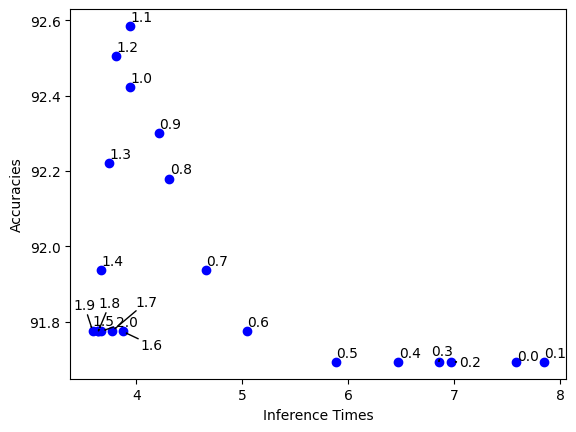

<Figure size 5e+06x5e+06 with 0 Axes>

In [60]:
from adjustText import adjust_text
entropy = [x/10 for x in range(0, 21)]
# Creating the scatter plot
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots()
scatter = ax.scatter(inference_times, accuracies, c='blue')

texts = []
for i, txt in enumerate(entropy):
    text = ax.annotate(str(txt), (inference_times[i], accuracies[i]))
    texts.append(text)

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
plt.figure(figsize=(50000, 50000))
ax.set_xlabel('Inference Times')
ax.set_ylabel('Accuracies')
plt.show()